# Simplifying things

The method used in chapter 2 has been written up in two python scripts, simplyifying the analysis process for a galaxy.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import groupPolylines
import pcaSpiralExtract
import spiralExtraction
import json

In [3]:
with open('classification-dump.json') as f: classifications = json.load(f)
with open('subject-dump.json') as f: subjects = json.load(f)
# print(json.dumps(list(cls[0]['links']['subjects']), indent=1))
index, _ = (next(iter(filter(
    lambda s: s[1] == '6ee8db8f-2a1e-4d10-bcb9-1e5ec84f8f10',
    ((i, list(s['locations'][0].items())[0][1].split('/')[-1].split('.')[0]) for i, s in enumerate(subjects))
))))

subjectId = subjects[index]['id']

classificationsOfSubject = list(filter(lambda c: c['links']['subjects'][0] == subjectId, classifications))
annotations = [c['annotations'] for c in classificationsOfSubject]
annotationsWithSpiral = [c[3]['value'][0]['value'] for c in annotations if len(c[3]['value'][0]['value'])]
spirals = [[a['points'] for a in c] for c in annotationsWithSpiral]
spiralsWithLengthCut = [
    [[p['x'], p['y']] for p in arm]
    for classification in spirals
    for arm in classification
    if len(arm) > 10
]
drawnArms = np.array([np.array(arm) for arm in spiralsWithLengthCut])

And then perform the algorithm!

In [4]:
res = spiralExtraction.fit(drawnArms, fullOutput=True)

Calculating distance matrix (this can be slow)
Clustering arms
Working on arm label 0
	[1 / 4] Cleaning points (2749 total)
	[2 / 4] Identifiying most representitive arm
	[3 / 4] Sorting points
	[4 / 4] Fitting Spline
Working on arm label 1
	[1 / 4] Cleaning points (2778 total)
	[2 / 4] Identifiying most representitive arm
	[3 / 4] Sorting points
	[4 / 4] Fitting Spline
Working on arm label 2
	[1 / 4] Cleaning points (163 total)
	[2 / 4] Identifiying most representitive arm
	[3 / 4] Sorting points
	[4 / 4] Fitting Spline
done!


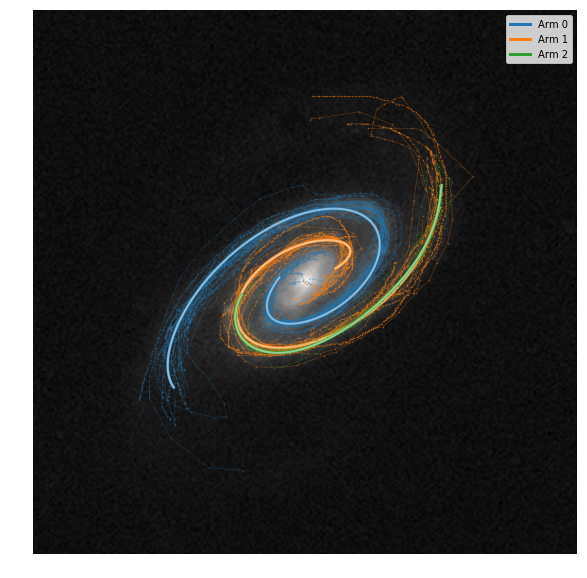

In [5]:
from PIL import Image
plt.figure(figsize=(10, 10))

pic = Image.open("./images/beta_subject.png")
plt.imshow(np.transpose(np.array(pic)[::-1, ::1]), cmap='gray', origin='lower')

t = np.linspace(0, 1, 1000)
for i, (Sx, Sy) in enumerate(res['functions']):
    for arm in drawnArms[res['labels'] == i]:
        plt.plot(
            arm[:, 0], arm[:, 1],
            '.-', c='C{}'.format(i),
            markersize=1, linewidth=0.4, alpha=0.5
        )
    plt.plot(
        (Sx(t) + 0.5) * 512, (Sy(t) + 0.5) * 512,
        c='C{}'.format(i), linewidth=3, label='Arm {}'.format(i)
    )
    plt.plot(
        (Sx(t) + 0.5) * 512, (Sy(t) + 0.5) * 512,
        c='w', linewidth=2, alpha=0.5
    )
plt.axis('off')
plt.legend()

### Next steps

Well it looks like we have a spiral! We still need to finalise start/end points, but the next step is to test how resilient this method is when using fewer classifications (i.e. does our retirement limit make sense?)

This test galaxy from the beta received 47 classifications, in the next chapter we'll explore what happens if we drop that to 10.

In [6]:
gal = {
    'RA': 160.65881, 'DEC': 23.95191, 'Z': 0.043594,
    'RUN': 5137, 'CAMCOL': 6, 'FIELD': 314, 'RERUN': 301,
    'SERSIC_BA': 0.576469, 'SERSIC_PHI': 43.1215,
    'PETRO_THETA': 22.2729,
}

In [23]:
deprojectedArms = [
    spiralExtraction.deprojectArm(gal['SERSIC_PHI'], gal['SERSIC_BA'], arm - 256) + 256
    for arm in drawnArms
]

NameError: name 'kwargs' is not defined

In [7]:
from astropy.wcs import WCS
from astropy.io import fits
import astropy.units as u
import sdssCutoutGrab as scg

# Lookup the source fits file (needed for the rotation matrix)
fname = 'fitsImages/{0}/{1}/frame-r-{0:06d}-{1}-{2:04d}.fits'.format(
    int(gal['RUN']),
    int(gal['CAMCOL']),
    int(gal['FIELD'])
)
print('Source fits file:', fname)

Source fits file: fitsImages/5137/6/frame-r-005137-6-0314.fits


In [8]:
wFits = WCS(fname)
print('\n\nWCS from fits image:', wFits)

# The SDSS pixel scale is 0.396 arc-seconds
fits_cdelt = 0.396 / 3600

phi = float(gal['SERSIC_PHI'])

# cutouts were chosen to be 4x Petrosean radius, and then scaled (including interpolation) to be 512x512 pixels
scale = 4 * (float(gal['PETRO_THETA']) / 3600) / 512

# This should be obtained from the image, as some were not square.
size_pix = np.array([512, 512])

# Create a new WCS object
w = WCS(naxis=2)
w.wcs.crpix = size_pix / 2
w.wcs.crval = np.array([float(gal['RA']), float(gal['DEC'])])
w.wcs.ctype = ['RA---TAN', 'DEC--TAN']
w.wcs.cunit = ['deg', 'deg']

# Copy the rotation matrix from the source FITS file, adjusting the scaling as needed
w.wcs.cd = [
    wFits.wcs.cd[0] / fits_cdelt * scale,
    wFits.wcs.cd[1] / fits_cdelt * scale
]

print('\n\nCreated WCS:')
print(w)



WCS from fits image: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 160.58559477  23.9670679406  
CRPIX : 1025.0  745.0  
CD1_1 CD1_2  : -1.92462688617e-05  0.000108307970595  
CD2_1 CD2_2  : 0.000108317299457  1.92097370132e-05  
NAXIS : 2048  1489


Created WCS:
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 160.65881  23.95191  
CRPIX : 256.0  256.0  
CD1_1 CD1_2  : -8.457035624403367e-06  4.759178894936426e-05  
CD2_1 CD2_2  : 4.75958881604288e-05  8.440983102929732e-06  
NAXIS : 0  0


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [9]:
r = float(gal['PETRO_THETA'])/3600

cx, cy = 256, 256
wCx, wCy = float(gal['RA']), float(gal['DEC'])

# find our line in world coordinates
x = r * np.sin(np.deg2rad(phi)) + wCx
y = r * np.cos(np.deg2rad(-phi)) + wCy

v = np.array([x - wCx, y - wCy])
v /= np.linalg.norm(v)

print(v)

ra_line, dec_line = w.wcs_world2pix([wCx, x], [wCy, y], 0)

axis_vector = np.subtract.reduce(
    np.stack(
        (ra_line, dec_line),
        axis=1
    )
)

normal_vector = np.dot([[0, 1], [-1, 0]], axis_vector) * float(gal['SERSIC_BA']) 
origin = np.array([cx, cy])

[0.68354772 0.72990583]


In [10]:
angle = 180 * np.arccos(axis_vector[1]/np.linalg.norm(axis_vector))/ np.pi
print(angle)
fitsFile = fits.open(fname)
imageData = scg.cutFits(
    fitsFile,
    float(gal['RA']), float(gal['DEC']),
    size=(4 * r * u.degree, 4 * r * u.degree)
)

140.62568014839408


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [11]:
from tempfile import NamedTemporaryFile
import requests
import os
from matplotlib.patches import Ellipse


deNormArm = lambda a: 512*(0.5 + a)

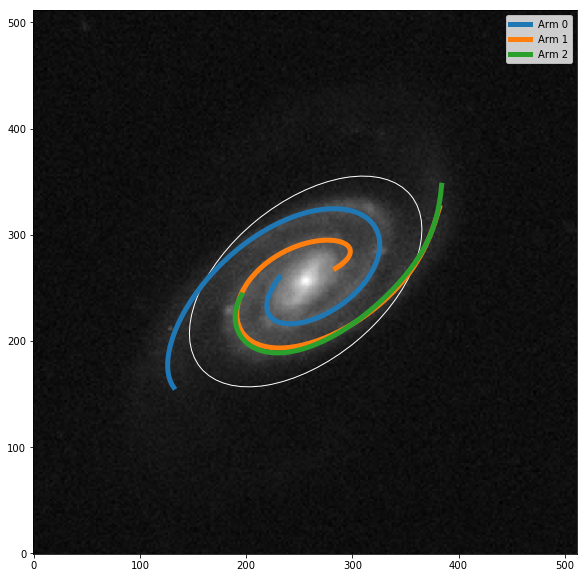

In [12]:
url = list(
    [s['locations'][0] for s in subjects if s['id'] == subjectId][0].values()
)[0]

imgData = requests.get(url).content

f = NamedTemporaryFile(suffix='.{}'.format(url.split('.')[-1]), delete=False)
f.write(imgData)
f.close()
pic = Image.open(f.name)
os.unlink(f.name)

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(np.array(pic), cmap='gray', origin='lower')

t = np.linspace(0, 1, 500)
for i, (Sx, Sy) in enumerate(res['functions']):
    plt.plot(deNormArm(Sx(t)), deNormArm(Sy(t)), linewidth=5, label='Arm {}'.format(i))
    
e = Ellipse(
    xy=(256, 256),
    width=256 * gal['SERSIC_BA'],
    height=256,
    angle=90-angle,
    ec='w',
    fc='none'
)
# plt.plot(*np.stack((origin, origin + axis_vector), axis=1), label='major axis')
# plt.plot(*np.stack((origin, origin + normal_vector), axis=1), label='minor axis')
ax.add_artist(e)
plt.legend()

Deproject the image of the galaxy:

/Users/tlingard/anaconda/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(-0.5, 511.5, -0.5, 511.5)

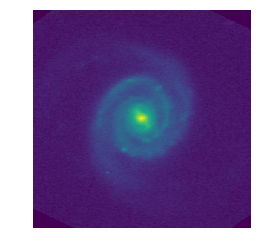

In [13]:
import skimage
from skimage.transform import rotate, rescale

rotatedImage = rotate(np.array(pic), 90-angle)
stretchedImage = rescale(rotatedImage, (1, 1/float(gal['SERSIC_BA'])))
n = int((stretchedImage.shape[1] - np.array(pic).shape[1]) / 2)

if n > 0: deprojectedImage = stretchedImage[:, n:-n]
else: deprojectedImage = stretchedImage.copy()

plt.imshow(deprojectedImage, origin='lower')
plt.axis('off')

In [14]:
def deprojectArm(phi, ba, arm):
    p = np.deg2rad(phi)
    Xs = 1/ba * (arm[:, 0] * np.cos(p) - arm[:, 1] * np.sin(p))
    Ys = 1 * (arm[:, 0] * np.sin(p) + arm[:, 1] * np.cos(p))
    
    return np.stack((Xs, Ys), axis=1)

Axes(0.125,0.125;0.352273x0.755)


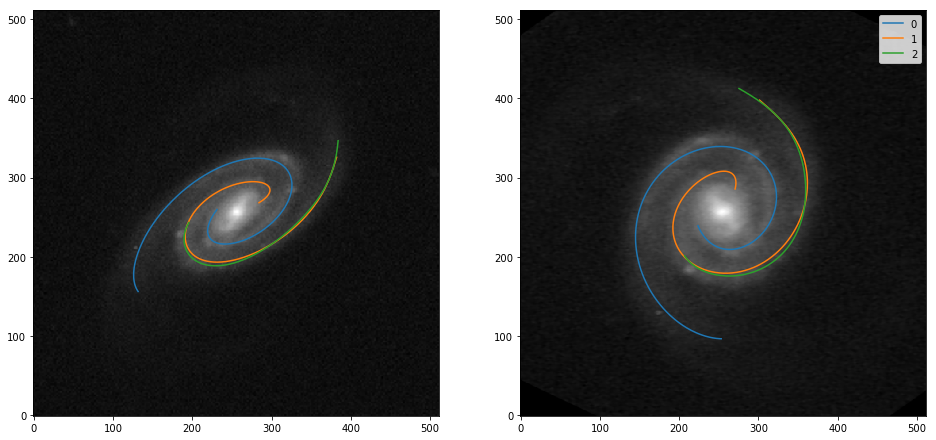

In [15]:
plt.figure(figsize=(16, 8))
ax = plt.subplot(121)
print(ax)
dpjArms = []
plt.imshow(pic, cmap='gray', origin='lower')
for Sx, Sy in res['functions']:
    arm = np.stack((Sx(t), Sy(t)), axis=1)
    deNormedArm = deNormArm(arm)
    plt.plot(deNormedArm[:, 0], deNormedArm[:, 1])
    deprojectedArm = deprojectArm(angle - 90, float(gal['SERSIC_BA']), arm)
    dpjArms.append(deprojectedArm)

plt.subplot(122)
plt.imshow(deprojectedImage, cmap='gray', origin='lower')
    
for i, arm in enumerate(dpjArms):
    arm = deNormArm(arm)
    plt.plot(arm[:, 0], arm[:, 1], label=i)
    
plt.legend()
# plt.axis('off')

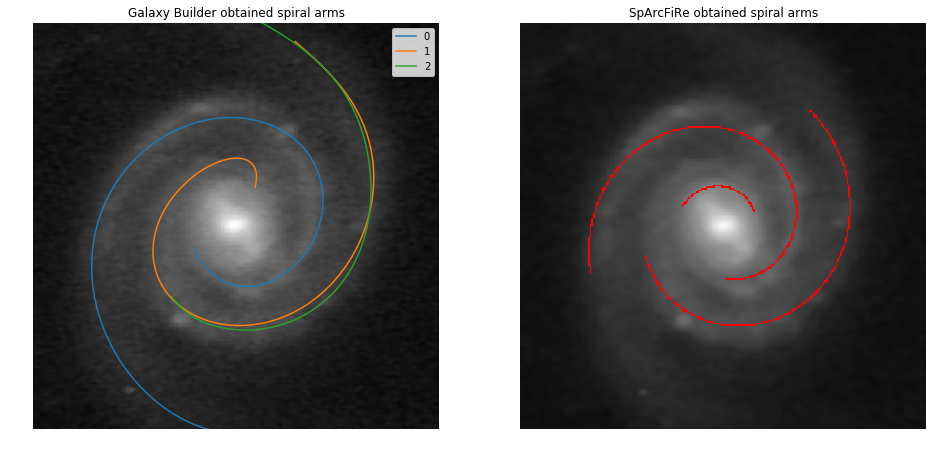

In [16]:
SpArcFiReResult = Image.open('./sparcfire_galaxy_image_11_data/image_11-J_logSpiralArcs-merged.png')

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(deprojectedImage, cmap='gray', origin='lower')
    
for i, arm in enumerate(dpjArms):
    arm = deNormArm(arm)
    plt.plot(arm[:, 0], arm[:, 1], label=i)
plt.axis('off')
plt.legend()
plt.title('Galaxy Builder obtained spiral arms')
plt.xlim(100, deprojectedImage.shape[0]-100)
plt.ylim(100, deprojectedImage.shape[1]-100)

plt.subplot(122)
plt.imshow(np.array(SpArcFiReResult)[::-1, ::-1], origin='lower')
plt.axis('off')
plt.title('SpArcFiRe obtained spiral arms')

In [17]:
Sx, Sy = res['functions'][0]
t = np.linspace(0, 1, 500)
arm = np.stack((Sx(t), Sy(t)), axis=1)
deprojectedArm = deprojectArm(90-angle, float(gal['SERSIC_BA']), arm)
pas = np.zeros(deprojectedArm.shape[0]-2)
O = np.array([0, 0])
for i in range(1, deprojectedArm.shape[0] - 1):
    pnm1 = deprojectedArm[i-1]
    pn = deprojectedArm[i]
    pnp1 = deprojectedArm[i + 1]
    unitTangent = (pnp1 - pnm1) / np.linalg.norm(pnp1 - pnm1)
    
    pas[i - 1] = np.pi/2 - np.arccos(np.dot(pn / np.linalg.norm(pn), unitTangent))

In [18]:
getRadius = lambda c: np.sqrt(np.add.reduce(c**2, axis=1))

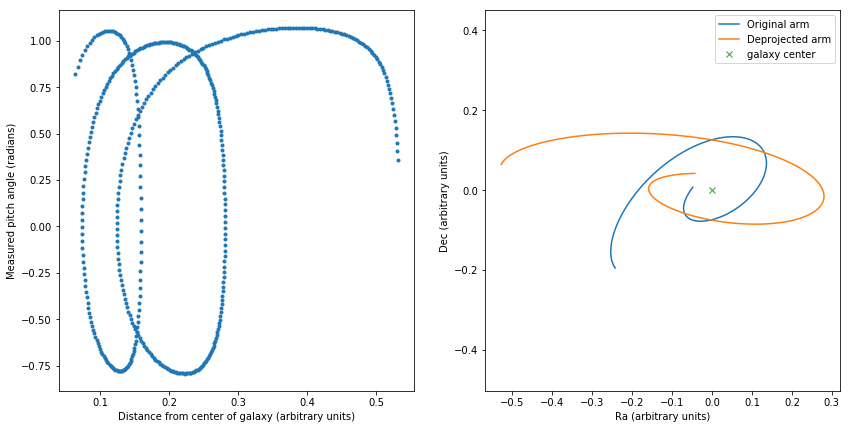

In [19]:
plt.figure(figsize=(14, 7))
plt.subplot(121)
plt.plot(getRadius(deprojectedArm[1: -1]), pas, '.')
plt.xlabel('Distance from center of galaxy (arbitrary units)')
plt.ylabel('Measured pitch angle (radians)')
plt.subplot(122)
plt.axis('equal')
plt.plot(arm[:,0], arm[:, 1], label='Original arm')
plt.plot(deprojectedArm[:, 0], deprojectedArm[:, 1], label='Deprojected arm')
plt.plot(0, 0, 'x', label='galaxy center')
plt.xlabel('Ra (arbitrary units)')
plt.ylabel('Dec (arbitrary units)')
plt.legend()